In [1]:
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input

#### Load Data

In [2]:
#load the dataframes created in the Data.ipynb section
X_train = pd.read_csv('..\data\X_train.csv')
X_val = pd.read_csv('..\data\X_val.csv')
X_test = pd.read_csv('..\data\X_test.csv')

y_train_bin = pd.read_csv('..\data\y_train_bin.csv')
y_val_bin = pd.read_csv('..\data\y_val_bin.csv')
y_test_bin = pd.read_csv('..\data\y_test_bin.csv')

y_train_multi = pd.read_csv('..\data\y_train_multi.csv')
y_val_multi = pd.read_csv('..\data\y_val_multi.csv')
y_test_multi = pd.read_csv('..\data\y_test_multi.csv')

In [3]:
#turn string labels into float categories, categs is list of categories
y_train_multi, categs = pd.factorize(y_train_multi.connection_category)
y_val_multi, categs = pd.factorize(y_val_multi.connection_category)
y_test_multi, categs = pd.factorize(y_test_multi.connection_category)
#turn float categories into tf.keras matrix categories of dimension length(categs)
#e.g. 'normal' = [1,0,0,0,0]
y_train_multi = to_categorical(y_train_multi, num_classes = len(categs))
y_val_multi = to_categorical(y_val_multi, num_classes = len(categs))
y_test_multi = to_categorical(y_test_multi, num_classes = len(categs))

## Training

In [4]:
def binaryDNN(train_df = X_train, hidden_nodes = [10,10,10], op = 'adam', metrics = [tf.keras.metrics.AUC()]):
    '''
    Function that takes dataframe train_df and creates a binary classifer neural network 
    with single node sigmoid output
    
    train_df = dataframe or array 
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final output
                   layer with a single node.
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    nn_model = Sequential()
    #input dimensions
    nn_model.add(Input(shape = (train_df.shape[1],)))
    
    #add layers
    for i in hidden_nodes:
        nn_model.add(Dense(i, activation = 'relu'))
        
    #output layer
    nn_model.add(Dense(1, activation = 'sigmoid'))
    
    #compile model
    nn_model.compile(loss='binary_crossentropy',optimizer=op,metrics=metrics)
    
    return nn_model

def multiDNN(train_df = X_train, num_classes = 5, hidden_nodes = [10,10,10], op = 'adam', metrics = ['accuracy']):
    '''
    Function that takes dataframe train_df and creates a binary classifer neural network 
    with single node sigmoid output
    
    train_df = dataframe or array 
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final output
                   layer with a single node.
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    nn_model = Sequential()
    #input dimensions
    nn_model.add(Input(shape = (train_df.shape[1],)))
    
    #add layers
    for i in hidden_nodes:
        nn_model.add(Dense(i, activation = 'relu'))
        
    #output layer
    nn_model.add(Dense(num_classes, activation = 'softmax'))
    
    #compile model
    nn_model.compile(loss='categorical_crossentropy',optimizer=op,metrics=metrics)
    
    return nn_model

Train binary and multiclass models for NAG, SGD, and Adam.

In [6]:
count = 1

start = time.time()

#5 learning rates equally spaced between 1/10,000 and 1/100
for eps in np.linspace(1/10000,1/100,5):
    
    eps = round(eps,5)
    #create the 3 optimizer with learning rate above
    sgd_opt = tf.keras.optimizers.SGD(learning_rate = eps,
                                      momentum = 0.9,
                                      nesterov = False)

#     nag_opt = tf.keras.optimizers.SGD(learning_rate = eps, 
#                                       momentum = 0.9, 
#                                       nesterov = True)
    
    
    # adam_opt = tf.keras.optimizers.Adam(learning_rate = eps)

    #fit same model architecture for each optimizer
    for opt in ['sgd']:
        #assign optimizer as above
        optimizer = locals()['{}_opt'.format(opt)] 
        
        #compile model with appropriate optimizer
        bin_model_temp = binaryDNN(op = optimizer)
        #record model history fitting to binary training data with validation split
        print('-'*10 + 'Fitting binary model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        bin_history_temp = bin_model_temp.fit(X_train, y_train_bin,
                                              shuffle = True, validation_data = (X_val, y_val_bin),
                                              epochs = 30, batch_size = 10000)
        
        #assign models and their history to appropriately named variable in locals()
        locals()['{}_bin_model_{}'.format(opt,count)] = bin_model_temp
        locals()['{}_bin_history_{}'.format(opt,count)] = bin_history_temp
        
        #delete temp model and history to free up memory
        del bin_model_temp
        del bin_history_temp
    
        #same as before but for multiclass categ
        categ_model_temp = multiDNN(op = optimizer)
        print('-'*10 + 'Fitting categorical model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        categ_history_temp = categ_model_temp.fit(X_train, y_train_multi,
                                                  shuffle = True, validation_data = (X_val, y_val_multi),
                                                  epochs = 30, batch_size = 10000)
    
        locals()['{}_categ_model_{}'.format(opt,count)] = categ_model_temp
        locals()['{}_categ_history_{}'.format(opt,count)] = categ_history_temp
         
        del categ_model_temp
        del categ_history_temp
        print()
        
    #increase count for iteration on next epsilon value
    count += 1
    
end = time.time()

----------Fitting binary model to sgd optimizer with learning rate 0.0001----------
Epoch 1/30
5/5 [==============================] - 3s 256ms/step - loss: 0.5904 - auc: 0.1622 - val_loss: 0.5890 - val_auc: 0.1601
Epoch 2/30
5/5 [==============================] - 0s 96ms/step - loss: 0.5872 - auc: 0.1659 - val_loss: 0.5844 - val_auc: 0.1651
Epoch 3/30
5/5 [==============================] - 0s 98ms/step - loss: 0.5820 - auc: 0.1704 - val_loss: 0.5784 - val_auc: 0.1714
Epoch 4/30
5/5 [==============================] - 0s 98ms/step - loss: 0.5757 - auc: 0.1774 - val_loss: 0.5718 - val_auc: 0.1795
Epoch 5/30
5/5 [==============================] - 0s 97ms/step - loss: 0.5689 - auc: 0.1877 - val_loss: 0.5648 - val_auc: 0.1946
Epoch 6/30
5/5 [==============================] - 0s 77ms/step - loss: 0.5619 - auc: 0.2010 - val_loss: 0.5578 - val_auc: 0.2081
Epoch 7/30
5/5 [==============================] - 0s 79ms/step - loss: 0.5549 - auc: 0.2157 - val_loss: 0.5508 - val_auc: 0.2242
Epoch 8/30
5

In [7]:
print('Time taken to run all models:  {:2f} seconds'.format(end-start))

Time taken to run all models:  109.172968 seconds


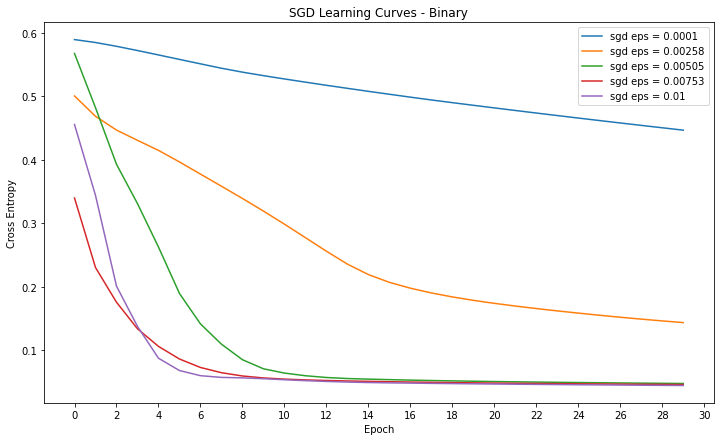

In [8]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Binary')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

plt.plot(sgd_bin_history_1.history['val_loss'],label='sgd eps = 0.0001')
plt.plot(sgd_bin_history_2.history['val_loss'],label='sgd eps = 0.00258')
plt.plot(sgd_bin_history_3.history['val_loss'],label='sgd eps = 0.00505')
plt.plot(sgd_bin_history_4.history['val_loss'],label='sgd eps = 0.00753')
plt.plot(sgd_bin_history_5.history['val_loss'],label='sgd eps = 0.01')

plt.legend()
plt.show()

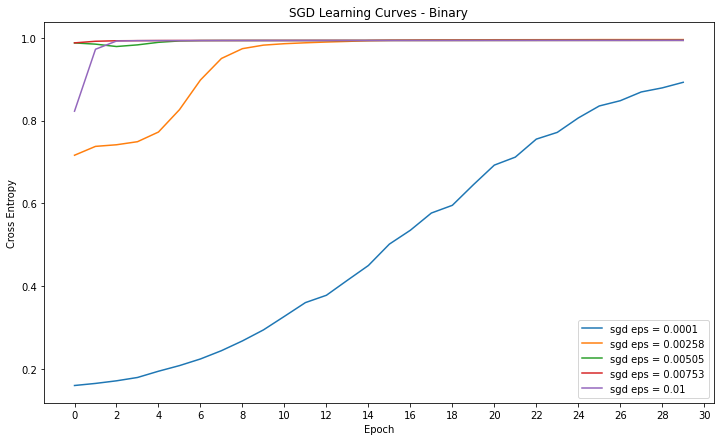

In [9]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Binary')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

plt.plot(sgd_bin_history_1.history['val_auc'],label='sgd eps = 0.0001')
plt.plot(sgd_bin_history_2.history['val_auc'],label='sgd eps = 0.00258')
plt.plot(sgd_bin_history_3.history['val_auc'],label='sgd eps = 0.00505')
plt.plot(sgd_bin_history_4.history['val_auc'],label='sgd eps = 0.00753')
plt.plot(sgd_bin_history_5.history['val_auc'],label='sgd eps = 0.01')

plt.legend()
plt.show()

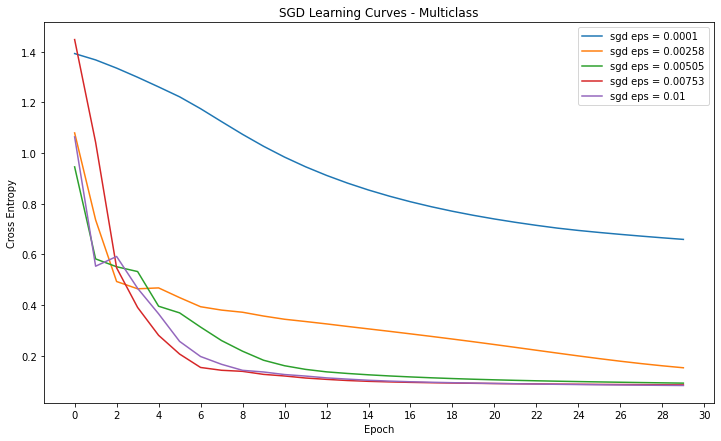

In [10]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Multiclass')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

plt.plot(sgd_categ_history_1.history['val_loss'],label='sgd eps = 0.0001')
plt.plot(sgd_categ_history_2.history['val_loss'],label='sgd eps = 0.00258')
plt.plot(sgd_categ_history_3.history['val_loss'],label='sgd eps = 0.00505')
plt.plot(sgd_categ_history_4.history['val_loss'],label='sgd eps = 0.00753')
plt.plot(sgd_categ_history_5.history['val_loss'],label='sgd eps = 0.01')

plt.legend()
plt.show()

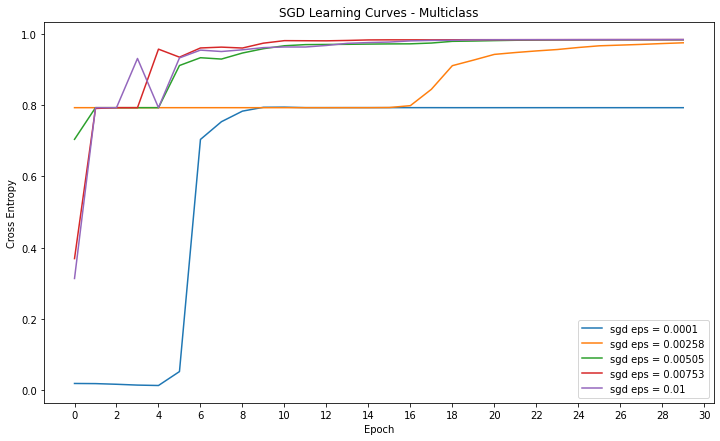

In [11]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Learning Curves - Multiclass')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

plt.plot(sgd_categ_history_1.history['val_accuracy'],label='sgd eps = 0.0001')
plt.plot(sgd_categ_history_2.history['val_accuracy'],label='sgd eps = 0.00258')
plt.plot(sgd_categ_history_3.history['val_accuracy'],label='sgd eps = 0.00505')
plt.plot(sgd_categ_history_4.history['val_accuracy'],label='sgd eps = 0.00753')
plt.plot(sgd_categ_history_5.history['val_accuracy'],label='sgd eps = 0.01')

plt.legend()
plt.show()

In [13]:
sgd_pred = sgd_bin_model_3.predict(X_test)

In [14]:
sgd_pred_bin = sgd_pred
sgd_pred_bin[sgd_pred_bin>0.5]=1
sgd_pred_bin[sgd_pred_bin<0.5]=0

In [15]:
from mlxtend.plotting import plot_confusion_matrix

In [16]:
import matplotlib

In [17]:
from sklearn.metrics import confusion_matrix

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

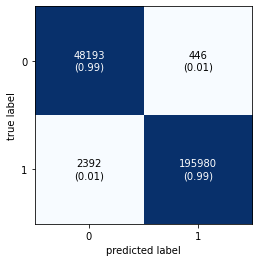

In [18]:
cmat_sgd = confusion_matrix(y_test_bin,sgd_pred)
cmat_sgd
plot_confusion_matrix(
    conf_mat = cmat_sgd,
    show_normed = True
)

In [19]:
sgd_categ_pred = sgd_categ_model_4.predict(X_test)

In [20]:
sgd_categ_pred

array([[9.8798394e-01, 3.1195774e-03, 4.6708388e-03, 4.0501249e-03,
        1.7554208e-04],
       [9.9783593e-01, 1.1966450e-03, 6.0433417e-04, 3.6070115e-04,
        2.4384983e-06],
       [1.1608812e-02, 9.8337644e-01, 4.1602342e-03, 4.2918252e-04,
        4.2525935e-04],
       ...,
       [9.9783593e-01, 1.1966444e-03, 6.0433417e-04, 3.6070077e-04,
        2.4384958e-06],
       [1.0004766e-01, 8.4036684e-01, 3.8859438e-02, 1.0967758e-02,
        9.7582666e-03],
       [9.9062026e-01, 1.6444534e-03, 3.7425747e-03, 3.8603549e-03,
        1.3243667e-04]], dtype=float32)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

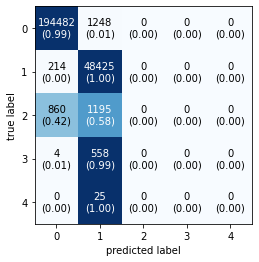

In [21]:
cmat_sgd = confusion_matrix(tf.argmax(y_test_multi,axis=1), tf.argmax(sgd_categ_pred,axis=1))

plot_confusion_matrix(
    conf_mat = cmat_sgd,
    show_normed = True
)